In [1]:
from google.colab import files
uploaded = files.upload()  # Upload the zipped dataset

Saving EuroSAT.zip to EuroSAT.zip


In [2]:
import zipfile
import os

# Unzip the uploaded file
zip_filename = list(uploaded.keys())[0]  # Get uploaded file name
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('./data')  # Extract to a "data" directory

# Set the directory for the dataset
train_dir = './data/2750'

In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [38]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10

In [39]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Flip images
    validation_split=0.2  # 20% validation data
)

In [40]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [41]:
# Load EfficientNetB0 as base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers[-20:]:  # Freeze first N layers, tune the rest
    layer.trainable = False



In [42]:
# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

In [43]:
# Compile Model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 189s 191ms/step - accuracy: 0.1473 - loss: 2.4263 - val_accuracy: 0.1430 - val_loss: 2.2924
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 165s 178ms/step - accuracy: 0.2366 - loss: 2.1676 - val_accuracy: 0.3665 - val_loss: 1.8954
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 121s 179ms/step - accuracy: 0.3291 - loss: 1.9483 - val_accuracy: 0.4287 - val_loss: 1.7886
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 120s 178ms/step - accuracy: 0.4203 - loss: 1.7660 - val_accuracy: 0.5661 - val_loss: 1.5535
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 120s 178ms/step - accuracy: 0.4831 - loss: 1.6260 - val_accuracy: 0.6204 - val_loss: 1.3953
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 119s 177ms/step - accuracy: 0.5481 - loss: 1.4713 - val_accuracy: 0.6439 - val_loss: 1.3103
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 120s 177ms/step - accuracy: 0.5842 - loss: 1.3574 - val_accuracy: 0.6715 - val_loss: 1.2201
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 119s 176ms/step - accuracy: 0.6204 -

In [45]:
# Save Model
model.save("efficientnet_lulc.h5")

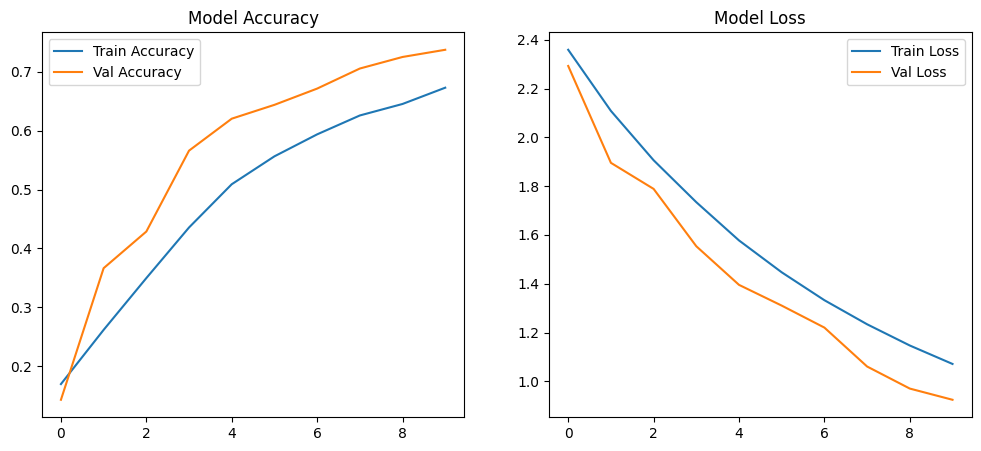

In [46]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [47]:
# Generate Predictions
y_true = []
y_pred = []

for i in range(len(val_generator)):
    images, labels = val_generator[i]
    preds = model.predict(images)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━

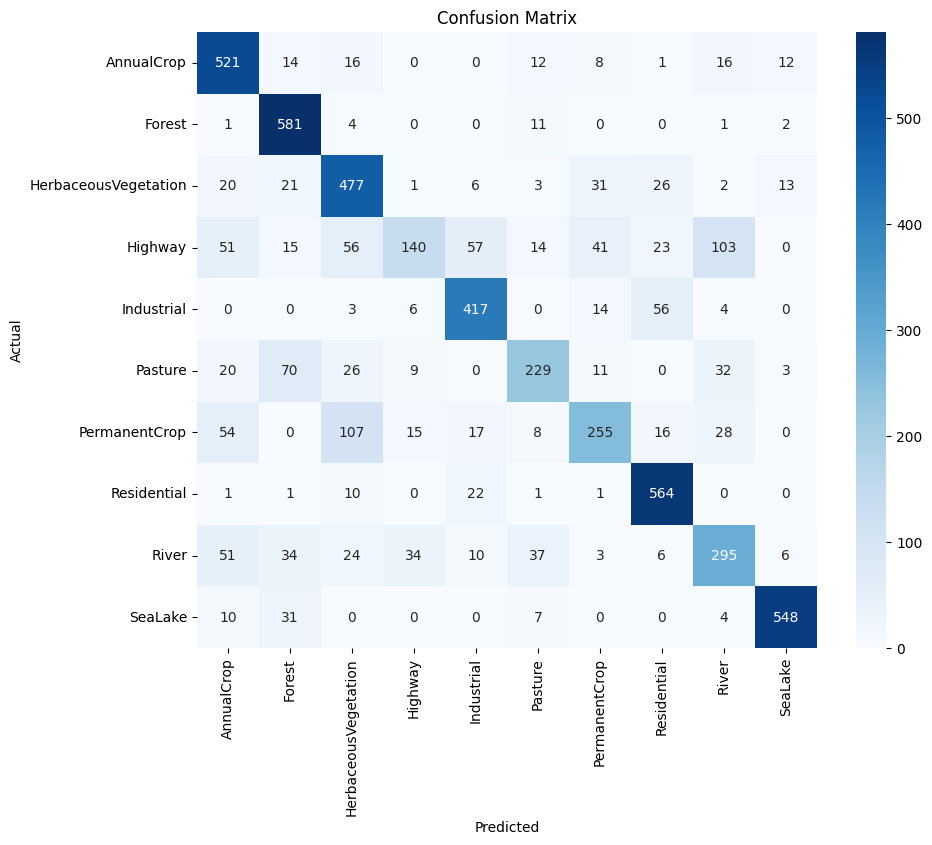

In [48]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [49]:
# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.71      0.87      0.78       600
              Forest       0.76      0.97      0.85       600
HerbaceousVegetation       0.66      0.80      0.72       600
             Highway       0.68      0.28      0.40       500
          Industrial       0.79      0.83      0.81       500
             Pasture       0.71      0.57      0.63       400
       PermanentCrop       0.70      0.51      0.59       500
         Residential       0.82      0.94      0.87       600
               River       0.61      0.59      0.60       500
             SeaLake       0.94      0.91      0.93       600

            accuracy                           0.75      5400
           macro avg       0.74      0.73      0.72      5400
        weighted avg       0.74      0.75      0.73      5400

